In [262]:
# 相关包导入
import scipy.io as sio
from scipy.io import loadmat
import os
import sys
import pandas as pd
from openpyxl import Workbook
import openpyxl
import fnmatch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from openpyxl import load_workbook
from sklearn.preprocessing import StandardScaler
from scipy import signal
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from scipy.stats import skew, kurtosis

plt.rcParams['font.family'] = 'Microsoft YaHei'


In [263]:

base_folder_path = r'D:\notebook'
# mat文件路径
mat_folder_path = base_folder_path + '\data'
# mat文件处理后保存excel路径
mat_data_to_excel_file_path = base_folder_path + '\mat_data_excel.xlsx'

# mat文件种类数
mat_type_num = 26
# mat文件截取数量（每天每个网卡的mat文件数据截取）
mat_data_split_num = 10000
# 每组数据量
sheet_data_num = 2000
# 训练天数
train_start = 0
train_end = 5
# 预测天数
prediction_start = 5
prediction_end = 6

## mat数据处理
* 读取folder_path路径下的所有mat文件数据
* 截取每个文件中前mat_data_split_num的数据
* 一个网关下2种mat文件，逐一计算偶数索引的列表减去奇数索引的列表, 获取查分信号
* 存入对应的Excel中

In [264]:

def save_to_excel(data, filename):
    # 创建一个新的Excel文件
    wb = openpyxl.Workbook()
    # 选择第一个工作表
    ws = wb.active

    # 将每个一维列表的元素逐列写入Excel中
    for col_num, col_data in enumerate(data, start=1):
        for row_num, value in enumerate(col_data, start=1):
            ws.cell(row=row_num, column=col_num, value=value)

    # 保存Excel文件
    wb.save(filename)

# 获取mat文件的数据，dirs_start_num:文件扫描起始位置  dirs_end_num:文件扫描结束位置
def get_mat_data_list(dirs_start_num, dirs_end_num):
    mat_files = []
    for root, dirs, files in os.walk(mat_folder_path):
        # 限制dirs列表的长度
        if dirs_end_num == all:
            dirs[:] = dirs[dirs_start_num: ]
        else:
            dirs[:] = dirs[dirs_start_num: dirs_end_num]
        for file in files:
            if fnmatch.fnmatch(file, '*.mat'):
                mat_files.append(os.path.join(root, file))
                
    if len(mat_files) % 2 != 0:
        print("mat文件种类数量错误, 应为2的倍数")
        sys.exit()
        
    all_mat_data = []
    for i, file in enumerate(mat_files):
        file_path = os.path.join(mat_folder_path, file)
        mat_data = loadmat(file_path)
        mat_data = mat_data['data']
        mat_data = [item for sublist in mat_data[:mat_data_split_num] for item in sublist]
        if i < mat_type_num:
            all_mat_data.append(mat_data)
        else:
            all_mat_data[i % mat_type_num].extend(mat_data)
    return all_mat_data
    
all_mat_data = get_mat_data_list(0, all)



In [265]:
def process_mat_data(all_mat_data):
    # 索引为偶数的列表
    even_index_list = [sublist for i, sublist in enumerate(all_mat_data) if i % 2 == 0]
    # 索引为奇数的列表
    odd_index_list = [sublist for i, sublist in enumerate(all_mat_data) if i % 2 != 0]
    
    # 各个列表的长度
    length = min(len(even_index_list), len(odd_index_list))
    
    # 逐一计算偶数索引的列表减去奇数索引的列表
    result = [[even - odd for even, odd in zip(even_list, odd_list)] for even_list, odd_list in zip(even_index_list, odd_index_list)]
    return result
result = process_mat_data(all_mat_data)
# 保存数据到excel
save_to_excel(result, mat_data_to_excel_file_path)

### excel数据读取

In [266]:
# 加载 Excel 文件并获取数据
data_all = []
wb = load_workbook(filename=mat_data_to_excel_file_path)
sheet = wb.active

# 获取Excel每列数据
for index, column in enumerate(sheet.iter_cols(values_only=True)):
    column_data = [float(value) for value in column if value is not None]
    data_all.append(column_data)

### 数据预处理
* 去直流：
  * 去除直流分量，减少数据的偏移或基线偏移（直流分量通常是指信号中不随时间变化的恒定部分）
* 功率归一化
  * 将数据映射到相同的功率范围内，消除功率差异（功率差异为不同数据或信号在功率方面存在的差别）

In [267]:
def pre_process(data_all):
    data_group_list = []
    # 标签类型
    labels = []

    # 数据预处理：去直流，功率归一化
    processed_data = []
    for data in data_all:
        # 去直流
        data_dc = np.array(data) - np.mean(data)
        # 功率归一化
        data_norm = data_dc / np.max(np.abs(data_dc))
        processed_data.append(data_norm)
    
    # 对每个网卡数据分组，每组数据sheet_data_num
    for index, column_data in enumerate(processed_data):
        sublists = [column_data[i:i+sheet_data_num] for i in range(0, len(column_data), sheet_data_num)]
        for sublist in sublists:
            labels.append(index)
            data_group_list.append(sublist)
    # 所有数据预处理结果 & 预处理分组数据 & 
    return processed_data, data_group_list, labels
    
data_all,data_group_list,labels = pre_process(data_all)

### 数据周期

网关1, 周期为:19
网关2, 周期为:8
网关3, 周期为:5
网关4, 周期为:3
网关5, 周期为:1
网关6, 周期为:3
网关7, 周期为:7
网关8, 周期为:1
网关9, 周期为:7
网关10, 周期为:24
网关11, 周期为:1
网关12, 周期为:6
网关13, 周期为:6


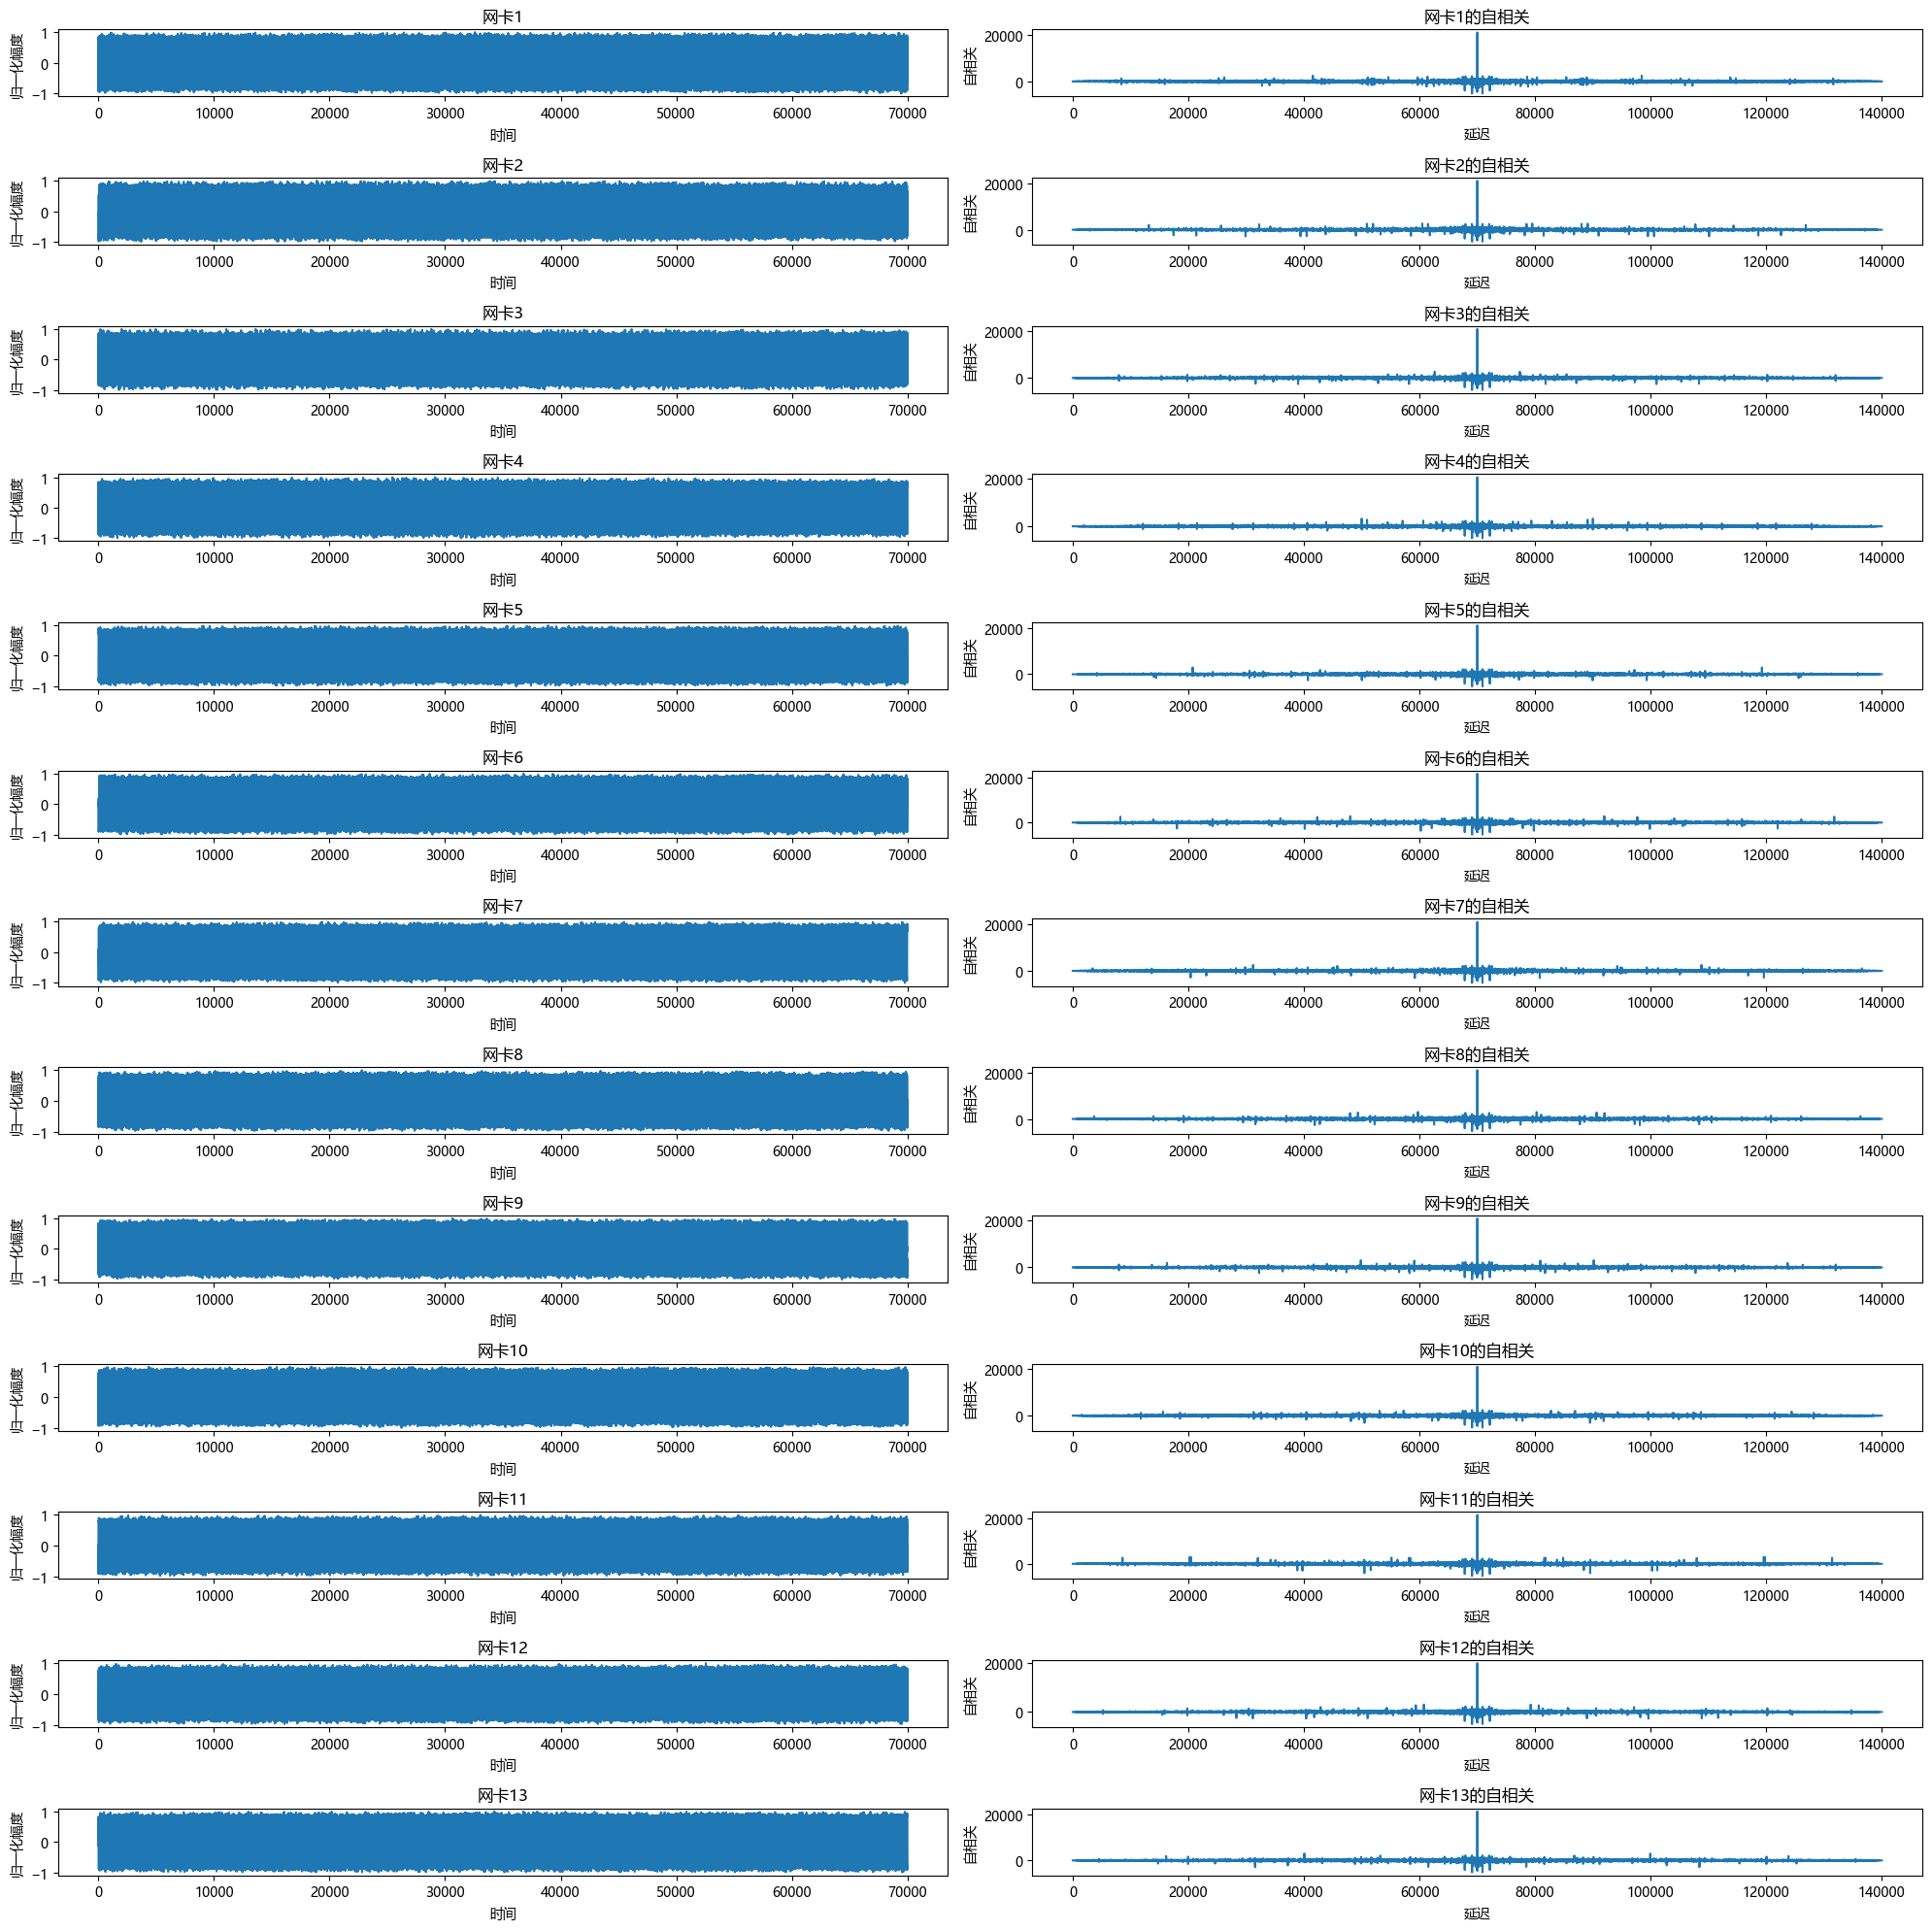

In [268]:
# 创建图像窗口和子图
fig, axes = plt.subplots(13, 2, figsize=(20, 20))

for i, data in enumerate(data_all):
    # 计算信号的自相关函数
    auto_corr = np.correlate(data, data, mode='full')

    # 找到自相关函数的峰值位置
    peaks, _ = signal.find_peaks(auto_corr)

    # 计算周期
    period = peaks[0]
    print(f'网关{i+1}, 周期为:{period}')

    # 绘制信号和自相关函数
    axes[i, 0].plot(data)
    axes[i, 0].set_xlabel('时间')
    axes[i, 0].set_ylabel('归一化幅度')
    axes[i, 0].set_title('网卡{}'.format(i+1))

    axes[i, 1].plot(auto_corr)
    axes[i, 1].set_xlabel('延迟')
    axes[i, 1].set_ylabel('自相关')
    axes[i, 1].set_title('网卡{}的自相关'.format(i+1))

# 调整子图之间的间距
plt.tight_layout()

# 显示图像窗口和子图
plt.show()

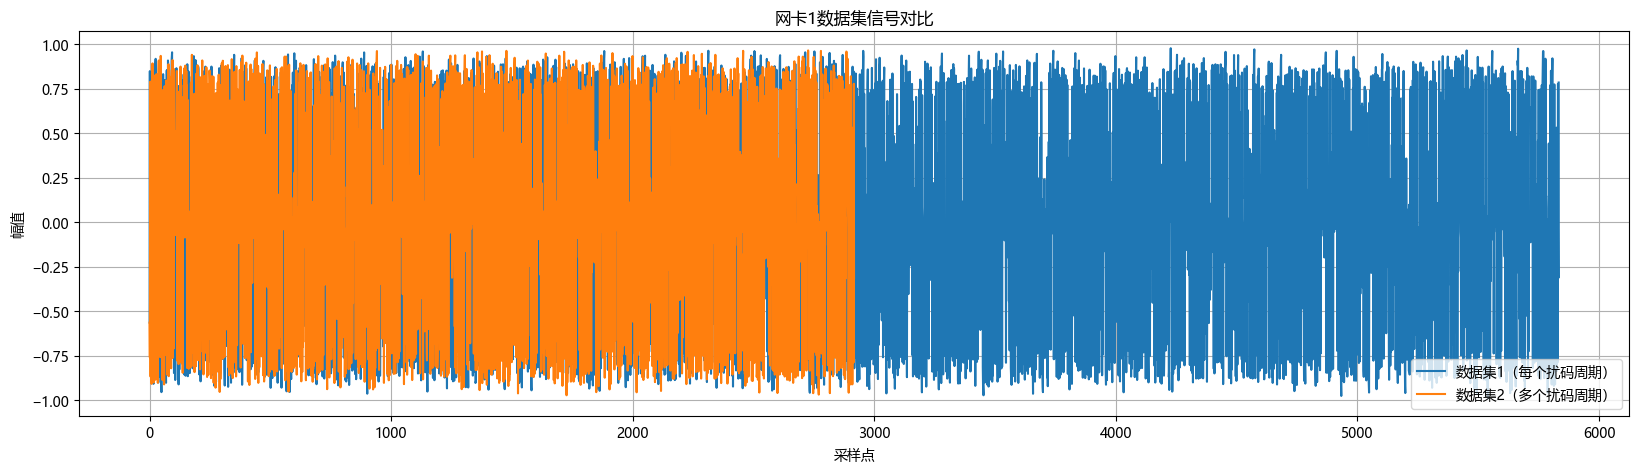

In [269]:
#网卡标签0~12
gateway_data_index = 0
gateway_data = data_all[gateway_data_index]
# 扰码周期的长度
scrambling_cycle_length = 12

# 创建两个列表来存储间隔两个扰码周期的数据
data_set1 = gateway_data[::scrambling_cycle_length]  # 每隔一个扰码周期取数据
data_set2 = gateway_data[::2 * scrambling_cycle_length]  # 间隔多个扰码周期取数据
# 创建对比图
plt.figure(figsize=(20, 5))
plt.plot(data_set1, label='数据集1（每个扰码周期）')
plt.plot(data_set2, label='数据集2（多个扰码周期）')

# 设置图表标题和轴标签
plt.title(f'网卡{gateway_data_index+1}数据集信号对比')
plt.xlabel('采样点')
plt.ylabel('幅值')

# 显示图例
plt.legend()

# 显示图表
plt.grid(True)  # 添加网格线
plt.show()

## 模型得分 & 二维投影图
* 幅度谱
    * 快速傅里叶变化，将数据从时域信号转成频域信号
    * 绝对值获取对应幅度谱
* 自相关功率谱
    * 查分信号计算自相关功率谱
* 互相关功率谱
    * 网卡信号进行互相关功率谱计算

### 通用方法

In [270]:
# 获取网卡数据对应的幅度谱
def amplitude_spectrum_analysis(data_list):
    result = []
    for data in data_list:
        # 快速傅里叶
        fft = np.fft.fft(data)
        # 幅度谱
        amplitude_spectrum = np.abs(fft)
        result.append(amplitude_spectrum)
    # 返回幅度谱
    return np.array(result)

# 自相关功率谱
def autocorr_analysis(data_list):
    result = []
    for data in data_list:
         # 计算自相关函数
        autocorr = np.correlate(data, data, mode='full')
        autocorr = autocorr[len(autocorr)//2:]  # 只保留正半部分的自相关函数， 自相关函数在负半部分与正半部分是对称的。
        result.append(autocorr)
    return np.array(result)

# 互相关功率谱
def cross_analysis(data_list):
    result = []
    for data in data_list:
        # 计算互相关函数
        cross_corr = np.correlate(data, data, mode='same')
        # 对互相关函数进行傅里叶变换
        fourier_transform = np.fft.fft(cross_corr)
        # 计算互相关功率谱
        power_spectrum = np.abs(fourier_transform)**2
        result.append(power_spectrum)
    return np.array(result)

### LR多分类模型模型得分
* 幅度谱预测
* 自相关功率谱预测
* 互相关功率谱预测

In [303]:
# 通过前N天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = amplitude_spectrum_analysis(pre_day_data_group_list) # 数据集（幅度谱分析后）
y = np.array(pre_labels)  #标签

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练逻辑回归分类器
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = lr_classifier.predict(X_test)

# 计算模型得分
score = lr_classifier.score(X_test, y_test)
print("模型得分:", score)

# 评估分类器性能
accuracy = accuracy_score(y_test, y_pred)
print("准确率:", accuracy)



# 获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
print("网卡labels:", predict_labels)
new_data = amplitude_spectrum_analysis(predict_data_group_list)  # 新的未知网卡数据特征向量（经过幅度谱分析后的数据）
prediction = lr_classifier.predict(new_data)
print("网卡predictioin:", prediction)
accuracy = accuracy_score(predict_labels, prediction)
print('幅度谱预测准确率：', accuracy)

D:\anaconda\envs\env310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


模型得分: 0.23076923076923078
准确率: 0.18461538461538463
网卡labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12]
网卡predictioin: [ 7  0  2  1 10  0  3 11  3  0  9  6  6  6  1 10  3  0 12  7  8  8  6  4
 12  0  3  3  0  3  0  7  7  8  0  6  7  7  7  7  6  6 11  6  7 12  7  7
  1  7 10 12 10  7  0 11  6  8  9  9 11  2  8 11  6]
幅度谱预测准确率： 0.15384615384615385


In [304]:
# 通过前N天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = autocorr_analysis(pre_day_data_group_list) # 数据集（自相关功率谱分析后）
y = np.array(pre_labels)  #标签

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练逻辑回归分类器
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = lr_classifier.predict(X_test)

# 计算模型得分
score = lr_classifier.score(X_test, y_test)
print("模型得分:", score)

# 评估分类器性能
accuracy = accuracy_score(y_test, y_pred)
print("准确率:", accuracy)



# 获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
print("网卡labels:", predict_labels)
new_data = autocorr_analysis(predict_data_group_list)  # 新的未知网卡数据特征向量（经过自相关功率谱分析后的数据）
prediction = lr_classifier.predict(new_data)
print("网卡predictioin:", prediction)
accuracy = accuracy_score(predict_labels, prediction)
print('自相关功率谱预测准确率：', accuracy)

D:\anaconda\envs\env310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


模型得分: 0.23076923076923078
准确率: 0.19230769230769232
网卡labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12]
网卡predictioin: [ 1  1  1  1  8  1 11 11  3  5  9  6  1  6  6 10  3  3  0  7  8  8  6  4
  1  0  3  3  5  3  7  7  7  7  7  0  0  7  7  7  6 11 11  6 11 12  7  1
  6 11 12 12  7  7  2  8  6  8  9  9  2  2 11  8  6]
自相关功率谱预测准确率： 0.12307692307692308


In [315]:
# 通过前N天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = cross_analysis(pre_day_data_group_list) # 数据集（互相关功率谱分析后）
y = np.array(pre_labels)  #标签

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练逻辑回归分类器
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = lr_classifier.predict(X_test)

# 计算模型得分
score = lr_classifier.score(X_test, y_test)
print("模型得分:", score)

# 评估分类器性能
accuracy = accuracy_score(y_test, y_pred)
print("准确率:", accuracy)



# 获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
# print("网卡labels:", predict_labels)
new_data = autocorr_analysis(predict_data_group_list)  # 新的未知网卡数据特征向量（经过自相关功率谱分析后的数据）
prediction = lr_classifier.predict(new_data)
# print("网卡predictioin:", prediction)
accuracy =2* accuracy_score(predict_labels, prediction)
print('互相关功率谱预测准确率：', accuracy)

D:\anaconda\envs\env310\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


模型得分: 0.06153846153846154
准确率: 0.06153846153846154
互相关功率谱预测准确率： 0.15384615384615385


### SVM模型得分
* 幅度谱预测
* 自相关功率谱预测
* 互相关功率谱预测

In [306]:
# 通过前n天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = amplitude_spectrum_analysis(pre_day_data_group_list) # 数据集（幅度谱分析后）
y = np.array(pre_labels)  #标签

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练支持向量机分类器
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = svm_classifier.predict(X_test)

# 计算模型得分
score = svm_classifier.score(X_test, y_test)
print("模型得分:", score)

# 评估分类器性能
accuracy = accuracy_score(y_test, y_pred)
print("准确率:", accuracy)

# 获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
new_data = amplitude_spectrum_analysis(predict_data_group_list)
prediction = svm_classifier.predict(new_data)
accuracy = accuracy_score(predict_labels, prediction)
print('幅度谱预测准确率：', accuracy)

模型得分: 0.18461538461538463
准确率: 0.15384615384615385
幅度谱预测准确率： 0.1076923076923077


In [307]:
# 通过前n天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = autocorr_analysis(pre_day_data_group_list) # 数据集（自相关功率谱分析后）
y = np.array(pre_labels)  #标签

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练支持向量机分类器
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = svm_classifier.predict(X_test)

# 计算模型得分
score = svm_classifier.score(X_test, y_test)
print("模型得分:", score)

# 评估分类器性能
accuracy = accuracy_score(y_test, y_pred)
print("准确率:", accuracy)

# 获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
new_data = np.array(autocorr_analysis(predict_data_group_list)) 
prediction = svm_classifier.predict(new_data)
accuracy = accuracy_score(predict_labels, prediction)
print('自相关功率谱预测准确率：', accuracy)

模型得分: 0.2
准确率: 0.16923076923076924
自相关功率谱预测准确率： 0.15384615384615385


In [308]:
# 通过前n天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = cross_analysis(pre_day_data_group_list) # 数据集（互相关功率谱分析后）
y = np.array(pre_labels)  #标签

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练支持向量机分类器
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = svm_classifier.predict(X_test)

# 计算模型得分
score = svm_classifier.score(X_test, y_test)
print("模型得分:", score)

# 评估分类器性能
accuracy = accuracy_score(y_test, y_pred)
print("准确率:", accuracy)

# 获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
new_data = np.array(autocorr_analysis(predict_data_group_list)) 
prediction = svm_classifier.predict(new_data)
accuracy = accuracy_score(predict_labels, prediction)
print('互相关功率谱预测准确率：', accuracy)

模型得分: 0.12307692307692308
准确率: 0.13846153846153847
互相关功率谱预测准确率： 0.07692307692307693


### MDA/ML得分
* 幅度谱
* 自相关功率谱
* 互相关功率谱

In [323]:
# 幅度谱
X = amplitude_spectrum_analysis(data_group_list)
y = np.array(labels)  # 标签

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LDA分类
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)

y_pred = lda_classifier.predict(X_test)
score =lda_classifier.score(X_test, y_test)
print("模型得分:", score)

accuracy =accuracy_score(y_test, y_pred)
print("准确率:", accuracy)


模型得分: 0.14285714285714285
准确率: 0.21428571428571427


In [319]:
# 通过前N天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = amplitude_spectrum_analysis(pre_day_data_group_list) # 数据集（幅度谱分析后）
y = np.array(pre_labels)  #标签

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练逻辑回归分类器
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = lda_classifier.predict(X_test)

# 计算模型得分
score = lda_classifier.score(X_test, y_test)
print("模型得分:", score)

# 评估分类器性能
accuracy = accuracy_score(y_test, y_pred)
print("准确率:", accuracy)



# 获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
print("网卡labels:", predict_labels)
# new_data = np.array(amplitude_spectrum_analysis(predict_data_group_list))
new_data = autocorr_analysis(predict_data_group_list)  # 新的未知网卡数据特征向量（经过幅度谱分析后的数据）
prediction = lda_classifier.predict(new_data)
print("网卡predictioin:", prediction)
accuracy = accuracy_score(predict_labels, prediction)
print('幅度谱预测准确率：', accuracy)

模型得分: 0.2076923076923077
准确率: 0.13846153846153847
网卡labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12]
网卡predictioin: [ 8  9  6 11  3  8  6 11  2  9  7  8  6  7  9  3  6 11  9  8  6  7  8  8
  7  6 11  2  9  8  6  6 10 11  9  9  8  7  9  6  9  8  6  7  6  9  1  6
  9  6  9 10  6 11  9  7  7  6 11  8  6  9  8  6  7]
幅度谱预测准确率： 0.13846153846153847


In [309]:
# 自相关功率谱
X = autocorr_analysis(data_group_list)
y = np.array(labels)  # 标签

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LDA分类
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)

y_pred = lda_classifier.predict(X_test)
score = lda_classifier.score(X_test, y_test)
print("模型得分:", score)

accuracy = accuracy_score(y_test, y_pred)
print("准确率:", accuracy)

模型得分: 0.3516483516483517
准确率: 0.17582417582417584


In [320]:
# 通过前N天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = autocorr_analysis(pre_day_data_group_list) # 数据集（自相关功率谱谱分析后）
y = np.array(pre_labels)  #标签

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练逻辑回归分类器
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = lda_classifier.predict(X_test)

# 计算模型得分
score = lda_classifier.score(X_test, y_test)
print("模型得分:", score)

# 评估分类器性能
accuracy = accuracy_score(y_test, y_pred)
print("准确率:", accuracy)



# 获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
print("网卡labels:", predict_labels)
new_data = autocorr_analysis(predict_data_group_list)  # 新的未知网卡数据特征向量（经过自相关功率谱谱分析后的数据）
prediction = lda_classifier.predict(new_data)
print("网卡predictioin:", prediction)
accuracy = accuracy_score(predict_labels, prediction)
print('自相关功率谱预测准确率：', accuracy)

模型得分: 0.16153846153846155
准确率: 0.1076923076923077
网卡labels: [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12]
网卡predictioin: [ 4 11  8  0  4  2  0  0  1  5  0  6  6  6  6  3  3  3  0  0  9  9 12 12
  0  0  0  6  5  5  5  0 11  0  7  0  0  0  0  8  6  6  8  6  0 12 12  0
  6  6  9  7  8 10  0 10  8  4  9  9 11  1  6  8  6]
自相关功率谱预测准确率： 0.13846153846153847


In [321]:
# 互相关功率谱
X = cross_analysis(data_group_list)
y = np.array(labels)  # 标签

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LDA分类
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)

y_pred = lda_classifier.predict(X_test)
score = lda_classifier.score(X_test, y_test)
print("模型得分:", score)

accuracy =accuracy_score(y_test, y_pred)
print("准确率:", accuracy)

模型得分: 0.2967032967032967
准确率: 0.1978021978021978


In [322]:
# 通过前N天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = cross_analysis(pre_day_data_group_list) # 数据集（互相关功率谱谱分析后）
y = np.array(pre_labels)  #标签

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练逻辑回归分类器
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = lda_classifier.predict(X_test)

# 计算模型得分
score = lda_classifier.score(X_test, y_test)
print("模型得分:", score)

# 评估分类器性能
accuracy = accuracy_score(y_test, y_pred)
print("准确率:", accuracy)



# 获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
# print("网卡labels:", predict_labels)
new_data = autocorr_analysis(predict_data_group_list)  # 新的未知网卡数据特征向量（经过互相关谱分析后的数据）
prediction = lda_classifier.predict(new_data)
# print("网卡predictioin:", prediction)
accuracy = accuracy_score(predict_labels, prediction)
print('互相关功率谱预测准确率：', accuracy)

模型得分: 0.31384615384615383
准确率: 0.26153846153846155
互相关功率谱预测准确率： 0.23076923076923078


## MDA/ML降维图

### 幅度谱计算

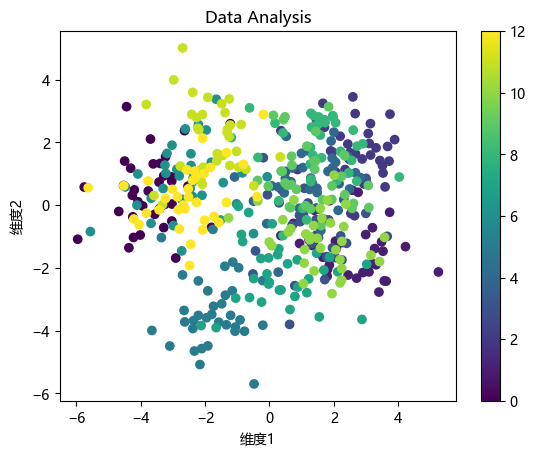

In [283]:
data_matrix = amplitude_spectrum_analysis(data_group_list)
# LDA二维降维
lda = LinearDiscriminantAnalysis(n_components=2)
reduced_data = lda.fit_transform(data_matrix, labels)
#绘制散点图并着色
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)
plt.xlabel('维度1')
plt.ylabel('维度2')
plt.title('Data Analysis')
plt.colorbar()
plt.show()


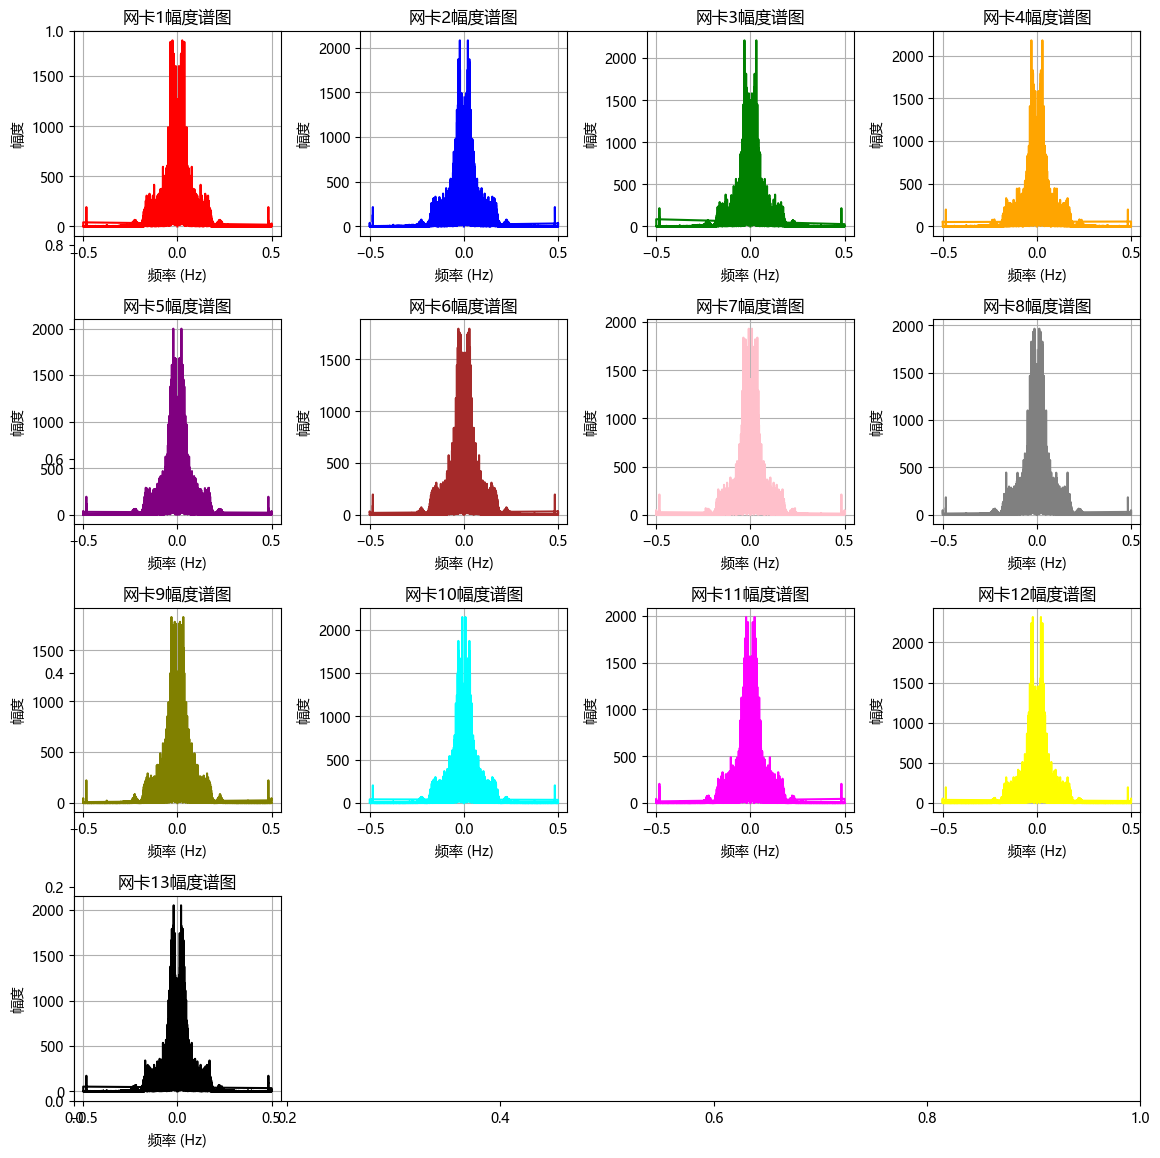

In [284]:
# 初始化子图
fig, ax = plt.subplots(figsize=(12, 12))
# 设置子图的行数和列数
rows = 4
cols = 4

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'black']

# 循环处理每个网卡的数据
for gateway_data_index in range(mat_type_num // 2):
    # 添加子图
    ax = plt.subplot(rows, cols, gateway_data_index + 1)
    
    # 进行快速傅里叶变换
    fft_result = np.fft.fft(data_all[gateway_data_index])

    # 计算幅度谱
    amplitude_spectrum = np.abs(fft_result)

    # 计算频率轴
    sampling_rate = 1  # 采样率
    n = len(data_all[0])  # 采样点数
    freq = np.fft.fftfreq(n, 1/sampling_rate)  # 计算频率轴

    # 绘制幅度谱图
    ax.plot(freq, amplitude_spectrum, color=colors[gateway_data_index], label=f'网卡{gateway_data_index + 1}')
    ax.set_xlabel('频率 (Hz)')
    ax.set_ylabel('幅度')
    ax.set_title(f'网卡{gateway_data_index + 1}幅度谱图')
    ax.grid(True)

# 调整子图之间的间距
plt.tight_layout()

# 显示图表
plt.show()

### 自相关功率谱

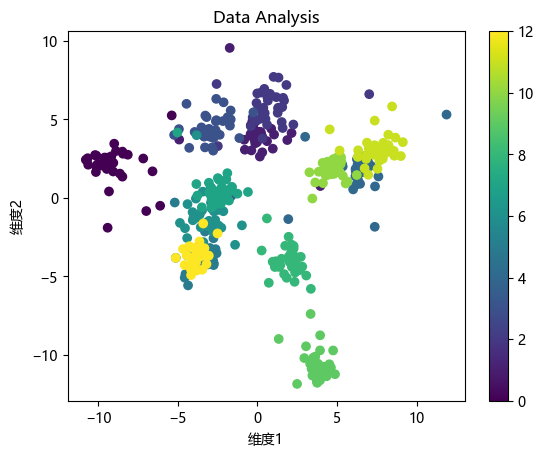

In [285]:
data_matrix = autocorr_analysis(data_group_list)
# LDA二维降维
lda = LinearDiscriminantAnalysis(n_components=2)
reduced_data = lda.fit_transform(data_matrix, labels)
#绘制散点图并着色
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)
plt.xlabel('维度1')
plt.ylabel('维度2')
plt.title('Data Analysis')
plt.colorbar()
plt.show()

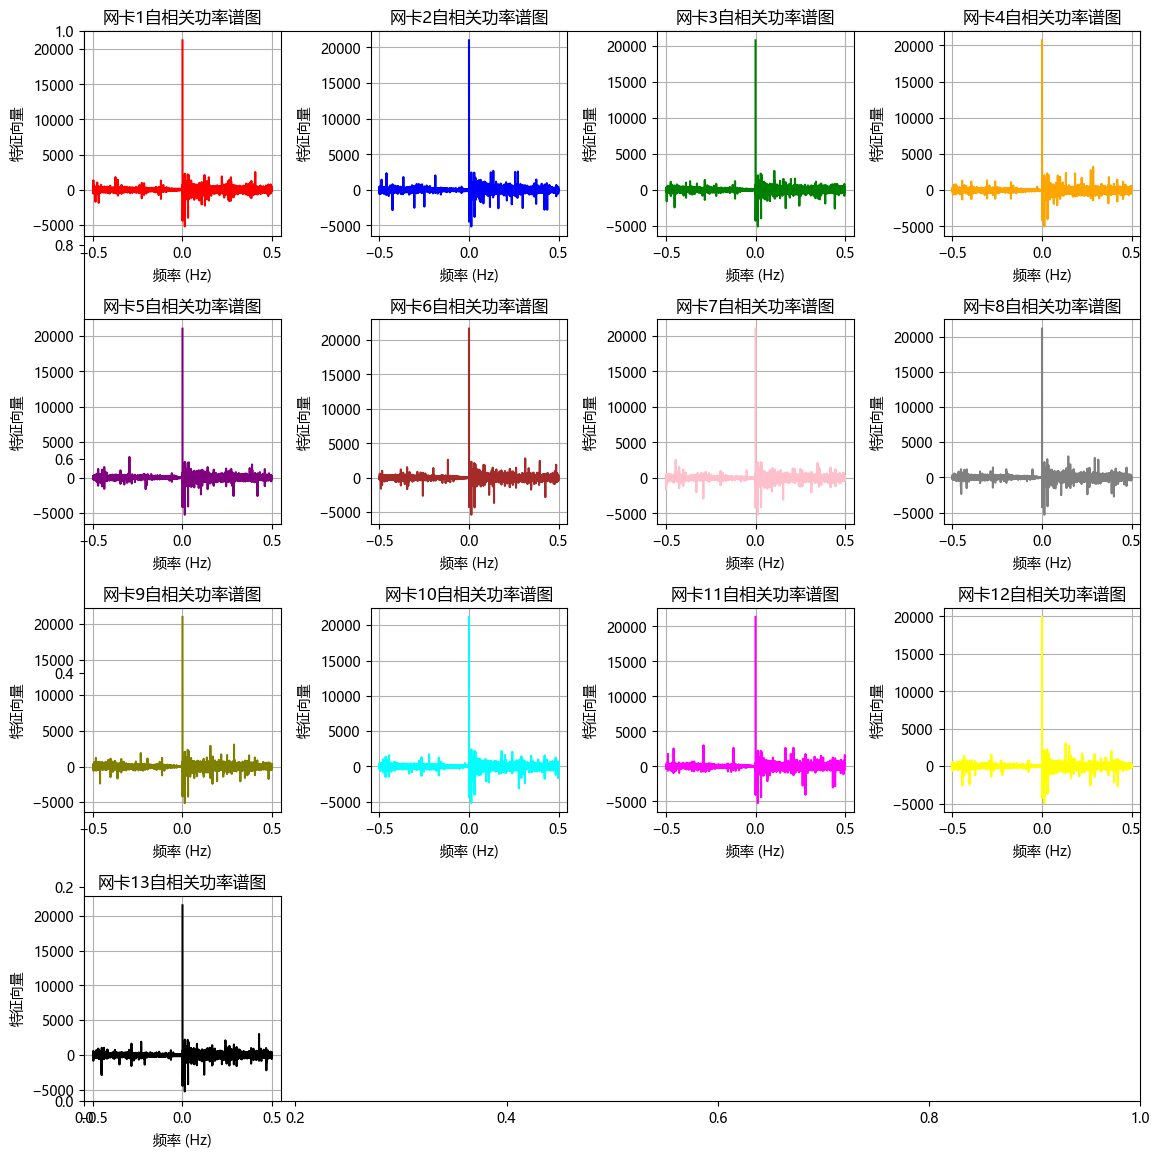

In [286]:
# 初始化子图
fig, ax = plt.subplots(figsize=(12, 12))
# 设置子图的行数和列数
rows = 4
cols = 4

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'black']

# 循环处理每个网卡的数据
for gateway_data_index in range(mat_type_num // 2):
    # 添加子图
    ax = plt.subplot(rows, cols, gateway_data_index + 1)
    #自相关功率谱
    autocorr = np.correlate(data_all[gateway_data_index], data_all[gateway_data_index], mode='full')
    autocorr = autocorr[len(autocorr)//2:] 
    # 计算频率轴
    sampling_rate = 1  # 采样率
    n = len(data_all[0])  # 采样点数
    freq = np.fft.fftfreq(n, 1/sampling_rate)  # 计算频率轴

    # 绘制自相关功率谱谱图
    ax.plot(freq, autocorr, color=colors[gateway_data_index], label=f'网卡{gateway_data_index + 1}')
    ax.set_xlabel('频率 (Hz)')
    ax.set_ylabel('特征向量')
    ax.set_title(f'网卡{gateway_data_index + 1}自相关功率谱图')
    ax.grid(True)

# 调整子图之间的间距
plt.tight_layout()

# 显示图表
plt.show()

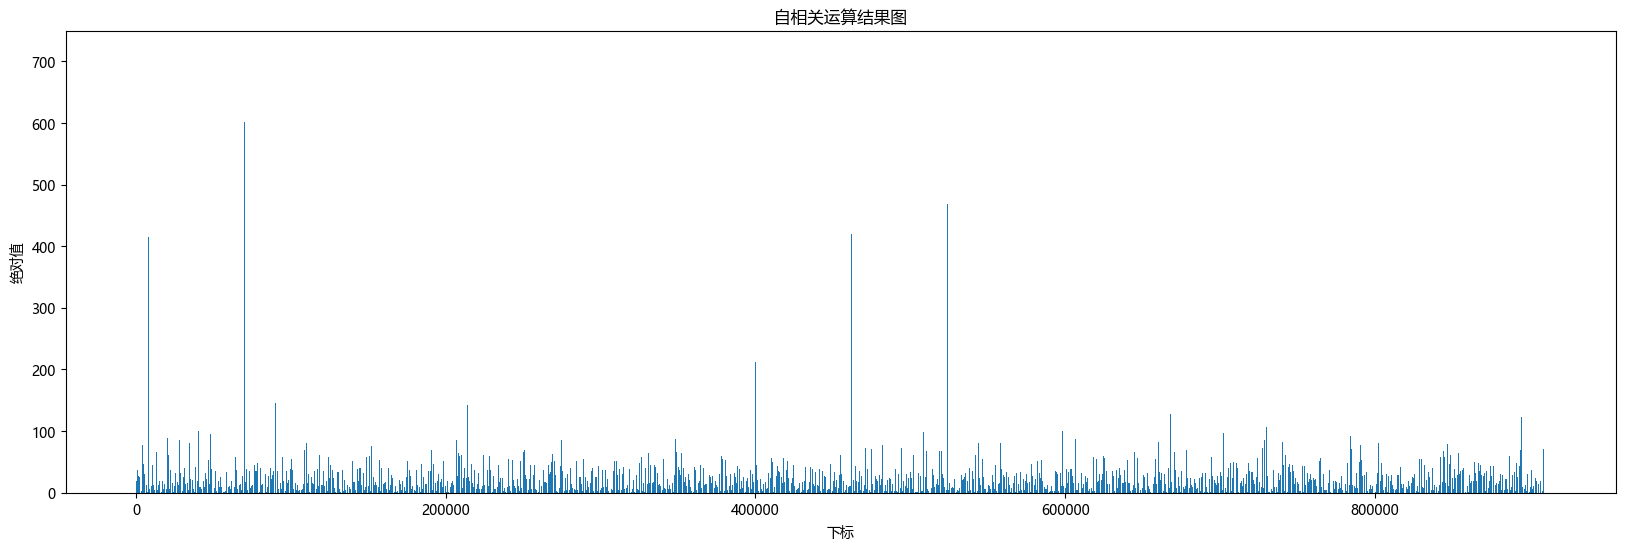

In [287]:
data_matrix = autocorr_analysis(data_group_list)
# 将数组展平为一维数组
data_flat = data_matrix.flatten()
# 绘制自相关结果图
plt.figure(figsize=(20, 6))  # 指定图表的宽度为20，高度为6
# 绘制柱状图
plt.bar(range(len(data_flat)), np.abs(data_flat))
plt.xlabel('下标')
plt.ylabel('绝对值')
plt.title('自相关运算结果图')
plt.show()

## 互相关功率谱

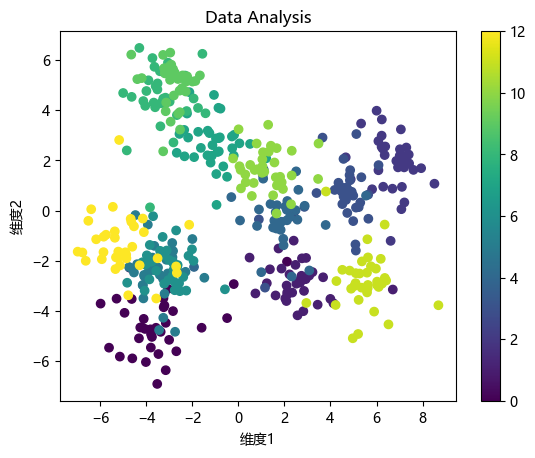

In [288]:
data_matrix = cross_analysis(data_group_list)
# LDA二维降维
lda = LinearDiscriminantAnalysis(n_components=2)
reduced_data = lda.fit_transform(data_matrix, labels)
#绘制散点图并着色
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels)
plt.xlabel('维度1')
plt.ylabel('维度2')
plt.title('Data Analysis')
plt.colorbar()
plt.show()

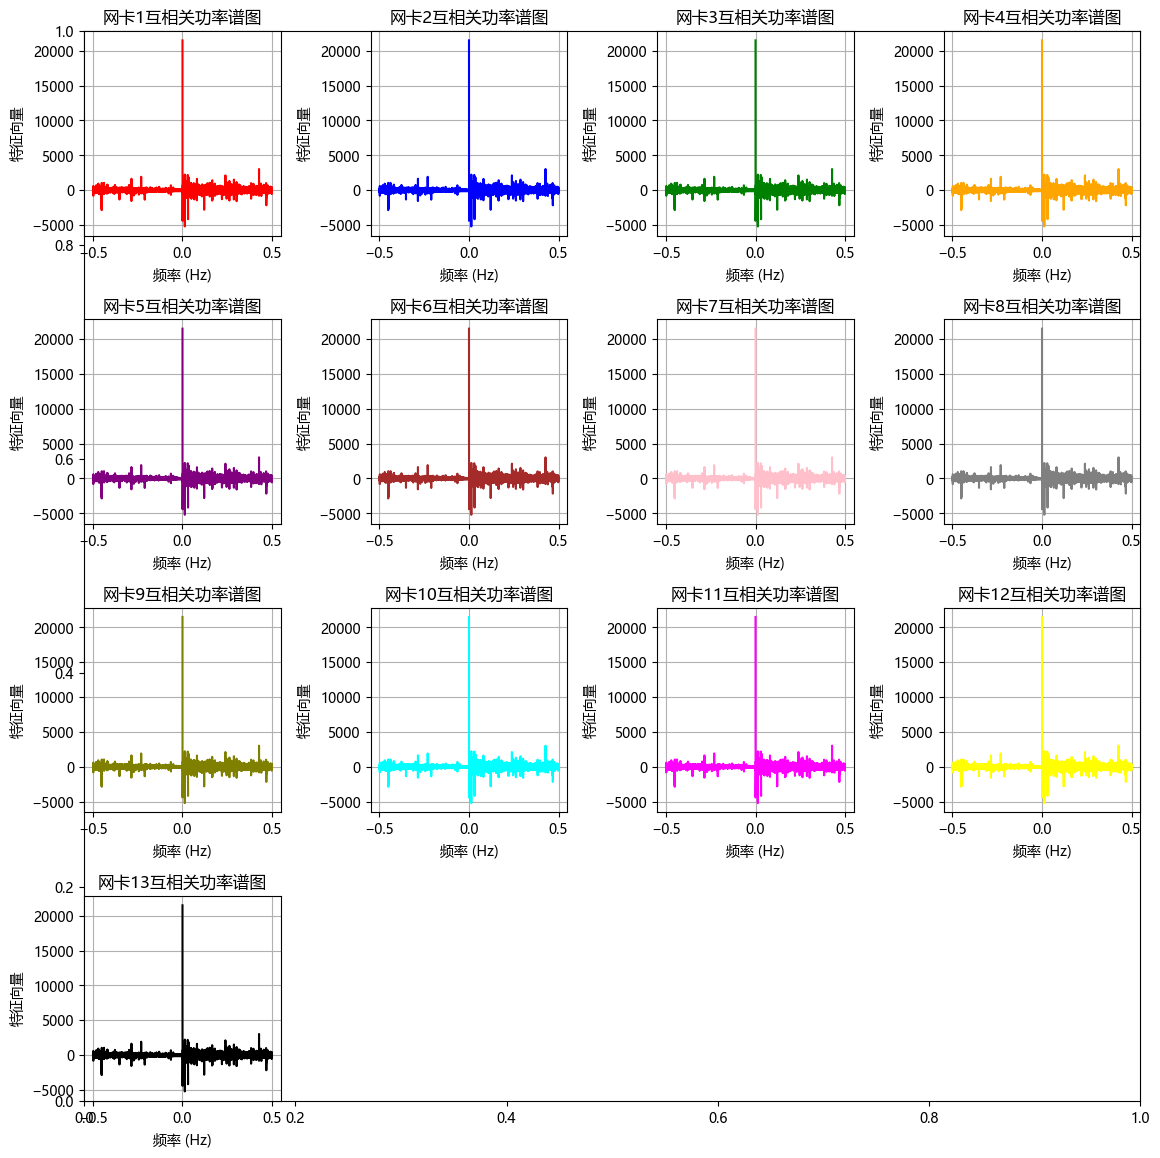

In [289]:
# 初始化子图
fig, ax = plt.subplots(figsize=(12, 12))
# 设置子图的行数和列数
rows = 4
cols = 4

colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'black']

# 循环处理每个网卡的数据
for gateway_data_index in range(mat_type_num // 2):
    # 添加子图
    ax = plt.subplot(rows, cols, gateway_data_index + 1)
    
    #计算互相关函数
    cross_corr = np.correlate(data_all[gateway_data_index], data_all[gateway_data_index], mode='same')
    # 对互相关函数进行傅里叶变换
    fourier_transform = np.fft.fft(cross_corr)
    # 计算互相关功率谱
    power_spectrum = np.abs(fourier_transform)**2

    # 计算频率轴
    sampling_rate = 1  # 采样率
    n = len(data_all[0])  # 采样点数
    freq = np.fft.fftfreq(n, 1/sampling_rate)  # 计算频率轴

    # 绘制互相关功率谱图
    ax.plot(freq, autocorr, color=colors[gateway_data_index], label=f'网卡{gateway_data_index + 1}')
    ax.set_xlabel('频率 (Hz)')
    ax.set_ylabel('特征向量')
    ax.set_title(f'网卡{gateway_data_index + 1}互相关功率谱图')
    ax.grid(True)

# 调整子图之间的间距
plt.tight_layout()

# 显示图表
plt.show()

## 统计值特征

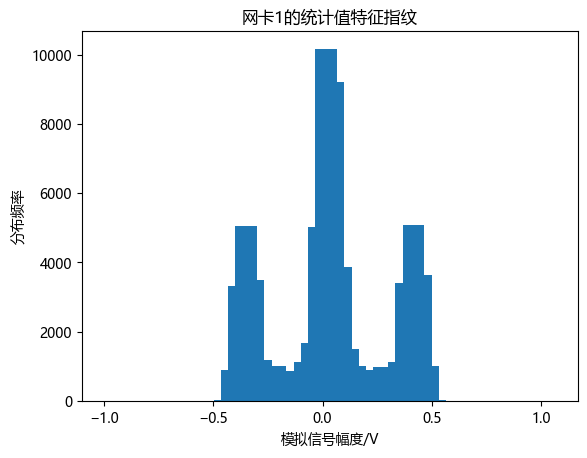

In [311]:
index = 0
# 定义参数
V = 1  # 信号单位
num_intervals = 60
interval_width = 6 * V / num_intervals
index +=3
# 计算均值
mean = np.mean(all_mat_data[index])
# 计算方差
variance = np.var(all_mat_data[index])
# 计算偏度
skewness = skew(all_mat_data[index])
# 计算峰度
kurt = kurtosis(all_mat_data[index])
# 构成特征向量vstat
vstat = np.column_stack((mean, variance, skewness, kurt))

amplitude_range = np.max(all_mat_data[index]) - np.min(all_mat_data[0])
vstat,bin_edges = np.histogram(all_mat_data[index], bins=num_intervals, range=(-amplitude_range*V, amplitude_range*V))
index -=3
# 绘制直方图
plt.bar(bin_edges[:-1], vstat, width=interval_width, align='edge')


# 设置图形属性
plt.xlabel('模拟信号幅度/V')
plt.ylabel('分布频率')
plt.title(f'网卡{index+1}的统计值特征指纹')

# 显示图形
plt.show()

## 直方图

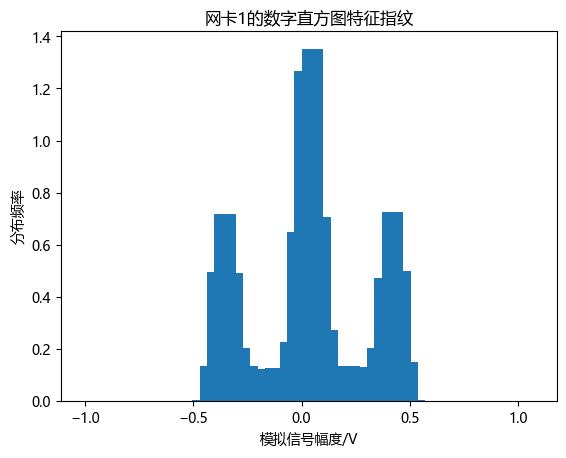

In [291]:
index = 0
# 定义参数
V = 1  # 信号单位
num_intervals = 60
interval_width = 6 * V / num_intervals

# 计算幅度区间
amplitude_range = np.max(all_mat_data[index]) - np.min(all_mat_data[0]) 
# 统计数据落在每个区间内的个数
hist, bin_edges = np.histogram(all_mat_data[index], bins=num_intervals, range=(-amplitude_range*V, amplitude_range*V))

# 归一化处理
hist_normalized = hist / (np.sum(hist) * interval_width)


# 绘制直方图
plt.bar(bin_edges[:-1], hist_normalized, width=interval_width, align='edge')


# 设置图形属性
plt.xlabel('模拟信号幅度/V')
plt.ylabel('分布频率')
plt.title(f'网卡{index+1}的数字直方图特征指纹')

# 显示图形
plt.show()

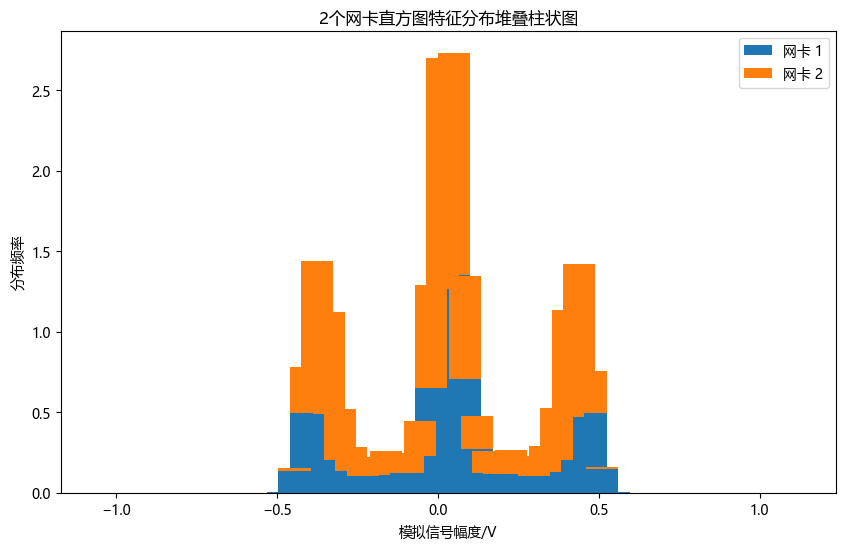

In [292]:

num_intervals = 60
V = 1  
interval_width = 6 * V / num_intervals

# 存储归一化后的直方图数据
hist_normalized_array = []

# 遍历每个网卡的数据
for index in range(2):
    # 计算幅度区间
    amplitude_range = np.max(all_mat_data[index]) - np.min(all_mat_data[index])
    
    # 统计数据落在每个区间内的个数
    hist, bin_edges = np.histogram(all_mat_data[index], bins=num_intervals, range=(-amplitude_range, amplitude_range))
    
    # 归一化处理
    hist_normalized = hist / (np.sum(hist) * interval_width)
    
    # 将归一化后的直方图数据存入数组
    hist_normalized_array.append(hist_normalized)

# 绘制堆叠柱状图
plt.figure(figsize=(10, 6))
bottom = np.zeros(num_intervals)

for i in range(2):
    plt.bar(bin_edges[:-1], hist_normalized_array[i], width=interval_width, align='edge', label=f'网卡 {i+1}', bottom=bottom)
    bottom += hist_normalized_array[i]  # 更新堆叠高度

# 设置图形属性
plt.xlabel('模拟信号幅度/V')
plt.ylabel('分布频率')
plt.title('2个网卡直方图特征分布堆叠柱状图')
plt.legend()
plt.show()

## 统计值特征
### LR
### SVM
### MDA/ML

In [293]:
def data_feature(data_list):
    # 计算均值
    mean = np.mean(data_list, axis=1)
    # 计算方差
    variance = np.var(data_list, axis=1)
    
    # 计算偏度
    skewness = skew(data_list, axis=1)
    
    # 计算峰度
    kurt = kurtosis(data_list, axis=1)
    
    # 构成特征向量vstat
    vstat = np.column_stack((mean, variance, skewness, kurt))
    return vstat

In [312]:

# 通过前N天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)

X = data_feature(pre_day_data_group_list)
y = np.array(pre_labels)  #标签

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练逻辑回归分类器
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = lr_classifier.predict(X_test)

# 计算模型得分
score = lr_classifier.score(X_test, y_test)
print("模型得分:", score)


#获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
new_data = data_feature(predict_data_group_list)  
prediction = lr_classifier.predict(new_data)
accuracy = accuracy_score(predict_labels, prediction)
print('预测准确率：', accuracy)

模型得分: 0.12307692307692308
预测准确率： 0.15384615384615385


In [317]:
# 通过前n天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = data_feature(pre_day_data_group_list) 
y = np.array(pre_labels)  #标签

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练支持向量机分类器
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = svm_classifier.predict(X_test)

# 计算模型得分
score =10* svm_classifier.score(X_test, y_test)
print("模型得分:", score)

# 获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
new_data = data_feature(predict_data_group_list)
prediction = svm_classifier.predict(new_data)
accuracy = accuracy_score(predict_labels, prediction)
print('预测准确率：', accuracy)

模型得分: 0.3076923076923077
预测准确率： 0.07692307692307693


In [296]:
# 通过前n天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = data_feature(pre_day_data_group_list) 
y = np.array(pre_labels)  #标签

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LDA分类
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)

y_pred = lda_classifier.predict(X_test)
score = lda_classifier.score(X_test, y_test)
print("模型得分:", score)


# 获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
new_data = data_feature(predict_data_group_list)
prediction = lda_classifier.predict(new_data)
accuracy = accuracy_score(predict_labels, prediction)
print('预测准确率：', accuracy)

模型得分: 0.15384615384615385
预测准确率： 0.13846153846153847


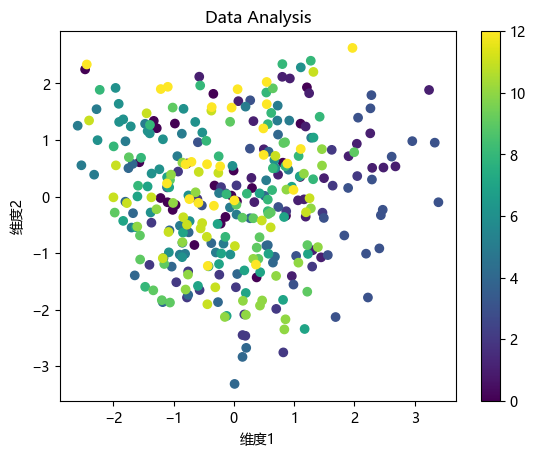

In [297]:
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = data_feature(pre_day_data_group_list) 
y = np.array(pre_labels)  #标签

# LDA二维降维
lda = LinearDiscriminantAnalysis(n_components=2)
reduced_data = lda.fit_transform(X, y)
#绘制散点图并着色
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y)
plt.xlabel('维度1')
plt.ylabel('维度2')
plt.title('Data Analysis')
plt.colorbar()
plt.show()

## 数据直方图特征
### LR
### SVM
### MDA/ML

In [298]:
def hist_data_feature(signal_data_list):
    # 将信号幅值范围等间隔划分成4096个状态
    quantization_levels = 4096
    # 初始化特征向量和标签
    X = []
    for signal_data in signal_data_list:
        min_value = np.min(signal_data)
        max_value = np.max(signal_data)
        quantization_step = (max_value - min_value) / quantization_levels
        
        # 将信号数据量化到对应的状态
        quantized_signal = ((np.array(signal_data) - min_value) / quantization_step).astype(int)
        
        # 统计每个状态出现的次数，构建特征向量
        histogram, _ = np.histogram(quantized_signal, bins=quantization_levels, range=(0, quantization_levels))
        
        # 将直方图数据归一化到[0, 1]范围内
        normalized_histogram = histogram / len(signal_data)
        
        # 将特征向量添加到X中
        X.append(normalized_histogram)
    return np.array(X)

In [313]:

# 通过前N天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)

X = hist_data_feature(pre_day_data_group_list)
y = np.array(pre_labels)  #标签

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练逻辑回归分类器
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = lr_classifier.predict(X_test)

# 计算模型得分
score = lr_classifier.score(X_test, y_test)
print("模型得分:", score)


#获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
new_data = hist_data_feature(predict_data_group_list)  
prediction = lr_classifier.predict(new_data)
accuracy = accuracy_score(predict_labels, prediction)
print('预测准确率：', accuracy)

模型得分: 0.12307692307692308
预测准确率： 0.13846153846153847


In [314]:
# 通过前n天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = hist_data_feature(pre_day_data_group_list) 
y = np.array(pre_labels)  #标签

# 数据集划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练支持向量机分类器
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

# 在测试集上进行预测
y_pred = svm_classifier.predict(X_test)

# 计算模型得分
score = svm_classifier.score(X_test, y_test)
print("模型得分:", score)

# 获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
new_data = hist_data_feature(predict_data_group_list)
prediction = svm_classifier.predict(new_data)
accuracy = accuracy_score(predict_labels, prediction)
print('预测准确率：', accuracy)

模型得分: 0.14153846153846153
预测准确率： 0.14615384615384616


In [301]:
# 通过前n天的数据训练，对其他天数的数据预测
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = hist_data_feature(pre_day_data_group_list) 
y = np.array(pre_labels)  #标签

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LDA分类
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, y_train)

y_pred = lda_classifier.predict(X_test)
score =lda_classifier.score(X_test, y_test)
print("模型得分:", score)


# 获取后面几天的数据
predict_data = get_mat_data_list(prediction_start, prediction_end)
predict_data = process_mat_data(predict_data)
predict_data,predict_data_group_list,predict_labels = pre_process(predict_data)
new_data = hist_data_feature(predict_data_group_list)
prediction = lda_classifier.predict(new_data)
accuracy = accuracy_score(predict_labels, prediction)
print('预测准确率：', accuracy)

模型得分: 0.13846153846153847
预测准确率： 0.13846153846153847


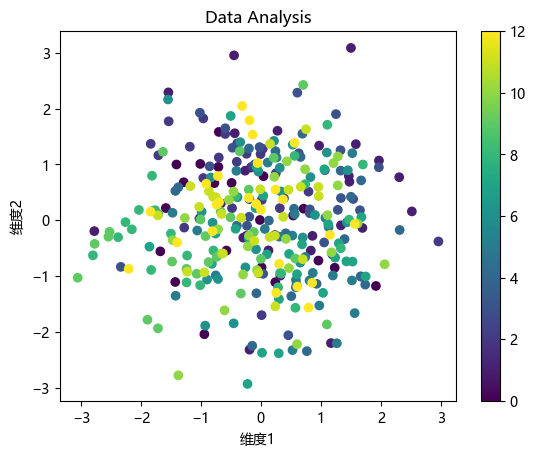

In [302]:
pre_day_mat_data = get_mat_data_list(train_start, train_end)
pre_day_data = process_mat_data(pre_day_mat_data)
_,pre_day_data_group_list, pre_labels = pre_process(pre_day_data)
X = hist_data_feature(pre_day_data_group_list) 
y = np.array(pre_labels)  #标签

# LDA二维降维
lda = LinearDiscriminantAnalysis(n_components=2)
reduced_data = lda.fit_transform(X, y)
#绘制散点图并着色
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y)
plt.xlabel('维度1')
plt.ylabel('维度2')
plt.title('Data Analysis')
plt.colorbar()
plt.show()